<a href="https://colab.research.google.com/github/adichiara/cs548/blob/master/CS_548_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy as stats
import scipy.stats as norm
from statistics import mean

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree.export import export_text
from sklearn import metrics
import random

#Data Preprocessing

In [0]:
# import dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', sep=",", header=None) 

In [0]:
# set column headers
column_names = ["age", "sex", "cp", "trestbps", "chol", 
              "fbs", "restecg", "thalach", "exang", 
              "oldpeak", "slope", "ca", "thal", "num"]
df.columns = column_names


In [0]:
# convert "?" values to NaN
df = df.replace("?", "")

# convert numeric string values to float
df.thal = pd.to_numeric(df.thal, errors='coerce')
df.ca = pd.to_numeric(df.ca, errors='coerce')

# recode target variable - multiple true values to single true value
df.num.replace(to_replace=[1,2,3,4], value=1, inplace=True)


In [0]:
pd.isna(df).sum()
  

In [0]:
# recode categorical variables with actual attribute descriptors

df_names = df.copy()

sex_dict = {1:"male",0:"female"}
cp_dict = {1:"typical angina",2:"atypical angina",3:"non-anginal pain",4:"asymptomatic"}
fbs_dict = {1:"true",0:"false"}
restecg_dict = {0:"normal",1:"ST-T wave abnormality",2:"left ventricular hypertrophy"}
exang_dict = {1:"yes",0:"no"}
slope_dict = {1:"upsloping",2:"flat",3:"downsloping"}
ca_dict = {0:"0 vessels",1:"1 vessels",2:"2 vessels",3:"3 vessels"}
thal_dict = {3:"normal",6:"fixed defect",7:"reversable defect"}
num_dict = {0:"<50% diameter narrowing",1:">50% diameter narrowing"}

df_names.sex.replace(to_replace=sex_dict, inplace=True)
df_names.cp.replace(to_replace=cp_dict, inplace=True) 
df_names.fbs.replace(to_replace=fbs_dict, inplace=True) 
df_names.restecg.replace(to_replace=restecg_dict, inplace=True) 
df_names.exang.replace(to_replace=exang_dict, inplace=True) 
df_names.slope.replace(to_replace=slope_dict, inplace=True) 
df_names.ca.replace(to_replace=ca_dict, inplace=True) 
df_names.thal.replace(to_replace=thal_dict, inplace=True) 
df_names.num.replace(to_replace=num_dict, inplace=True) 


In [0]:
#drop all observations rows with NaN data
df = df.dropna()
#re-index the dataframe so that there are no missing row index numbers.  
df = df.reset_index(drop=True)

# Dataset Exploration

In [0]:
vars_discrete = df_names.select_dtypes(include=['object']).columns

vars_continuous = ["age","trestbps","chol","thalach","oldpeak"]


In [0]:
df.shape

(303, 14)

In [0]:
df.describe()

In [0]:
# plot value frequencies for discrete variables

plt.rcParams['figure.figsize'] = [4,2]


for i, col in enumerate(vars_discrete):
  plt.figure(i) 
  ax = sns.countplot(y=col, data=df_names)


In [0]:
n=len(vars_discrete)

fig,ax = plt.subplots(n,1, figsize=(5,n*2), sharex=False)
for i in range(n):
    plt.sca(ax[i])
    col = vars_discrete[i]
    sns.countplot(y=df_names[col].values, hue=df_names.num)
    plt.xlabel("")
    plt.title(col)
    plt.subplots_adjust(top=1.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
 

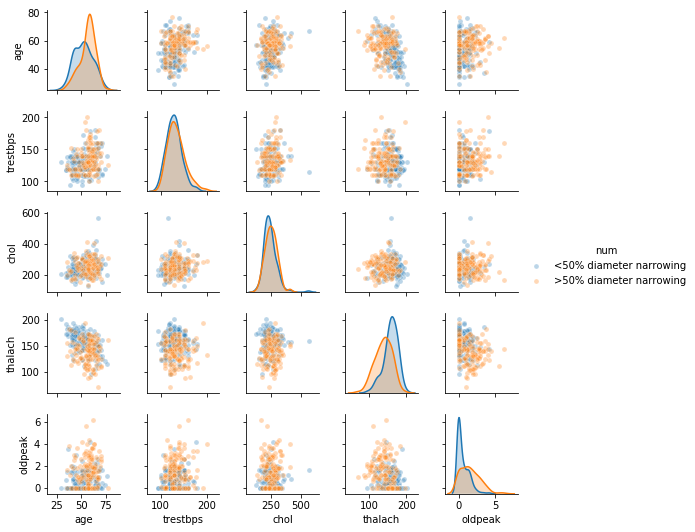

In [0]:

sns.pairplot(df_names, vars=vars_continuous, hue="num", height=1.5, plot_kws={"s":25, "alpha":.3} )



In [0]:
df[vars_discrete].corr()


In [0]:
plt.rcParams['figure.figsize'] = [10, 5]

df_true=df.loc[df.num==1,:]
df_false=df.loc[df.num==0,:]

# correlation heatmap
sns.heatmap(df_true[vars_discrete].corr(), 
            vmin=-1, vmax=1, center=0, 
            annot=True, fmt=".2f", linewidth=0.5,
            cmap="coolwarm_r")



In [0]:
# correlation heatmap
sns.heatmap(df_false[vars_discrete].corr(), 
            vmin=-1, vmax=1, center=0, 
            annot=True, fmt=".2f", linewidth=0.5,
            cmap="coolwarm_r")

# Classification functions

In [0]:
# decision tree classifier - 10 fold CV
def run_10fold_tree_classifier(x, y, model=tree.DecisionTreeClassifier()):

  accuracy_list=[]
  error_list=[]
  precision_list=[]
  recall_list=[]
  auc_list=[]
  
  # set kfold split generator
  kf = KFold(n_splits=10, shuffle=True)

  # iterate through folds
  for train, test in kf.split(x):
    
    x_train = x.iloc[train,:]
    x_test = x.iloc[test,:]  
    y_train = y[train]      
    y_test = y[test]         
      
    model = model.fit(x_train, y_train)
    pred = model.predict(x_test)

    # get performance stats
    accuracy = metrics.accuracy_score(y_test, pred)
    error = 1-accuracy
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    auc = metrics.roc_auc_score(y_test, pred)
    
    # append performance metrics to list for all folds
    accuracy_list.append(accuracy)
    error_list.append(error)
    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(auc)

  # return dictionary of mean metric scores
  return({"accuracy":mean(accuracy_list),
          "error":mean(error_list),
          "precision":mean(precision_list),
          "recall":mean(recall_list),
          "auc":mean(auc_list)
         }
        )
          
         


In [0]:
# zeroR benchmark classifier - 10 fold CV
def run_10fold_zeroR(y):

  accuracy_list=[]
  error_list=[]
  precision_list=[]
  recall_list=[]
  auc_list=[]
  
  # set kfold split generator
  kf = KFold(n_splits=10, shuffle=True)

  # iterate through folds
  for train, test in kf.split(y):
    
    y_train = y[train]      
    y_test = y[test]         
    
    # find most common class
    # returns array of unique variable categories, descending by most freq.
    # save to list of same length as y_test
    pred = [y_train.value_counts().index[0]] * len(y_test)

    # get performance stats
    accuracy = metrics.accuracy_score(y_test, pred)
    error = 1-accuracy
    recall = metrics.recall_score(y_test, pred)
    auc = metrics.roc_auc_score(y_test, pred)
    
    # for precision, skip calculation if no positive classifications 
    # to avoid undefined (zero denominator)
    if sum(pred)==0:
      precision = 0
    else: 
      precision = metrics.precision_score(y_test, pred)

    # append performance metrics to list for all folds
    accuracy_list.append(accuracy)
    error_list.append(error)
    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(auc)

  # return dictionary of mean metric scores
  return({"accuracy":mean(accuracy_list),
          "error":mean(error_list),
          "precision":mean(precision_list),
          "recall":mean(recall_list),
          "auc":mean(auc_list)
         }
        )
          
         

In [0]:
# oneR benchmark classifier - 10 fold CV
def run_10fold_oneR(x, y):

  accuracy_list=[]
  error_list=[]
  precision_list=[]
  recall_list=[]
  auc_list=[]
  
  # set kfold split generator
  kf = KFold(n_splits=10, shuffle=True)

  # iterate through folds
  for train, test in kf.split(y):
    x_train = x.iloc[train,:]
    x_test = x.iloc[test,:]  
    y_train = y[train]      
    y_test = y[test]   
    
    pred = pd.DataFrame(index=y_test.index.copy()) 

    scores=pd.DataFrame(data=[],
                        columns=["attribute",
                                  "accuracy",
                                  "error",
                                  "precision",
                                  "recall",
                                  "auc"])
      
    for i, col in enumerate(x_train):
     
      # find most common class
      # returns array of unique variable categories, descending by most freq.
      # save to list of same length as y_test
      pred_val = {}
      
      # for each category within attribute, determine predicted class
      for val in x_train[col].unique():
        train_matches = x_train.index[x_train[col] == val].tolist()
        pred_val[val] = y_train[train_matches].value_counts().index[0]
        test_matches = x_test.index[x_test[col] == val].tolist()
        pred.loc[test_matches,col] = pred_val[val]
        
      # save performance stats (add small random value for tiebreaking)
      scores.loc[i,"attribute"]=col
      scores.loc[i,"accuracy"]=metrics.accuracy_score(y_test, pred[col]) +random.random()*.0001
      scores.loc[i,"error"]=1-metrics.accuracy_score(y_test, pred[col]) +random.random()*.0001
      scores.loc[i,"recall"]=metrics.recall_score(y_test, pred[col]) +random.random()*.0001
      scores.loc[i,"auc"]=metrics.roc_auc_score(y_test, pred[col]) +random.random()*.0001
    
      # for precision, skip calculation if no positive classifications 
      # to avoid undefined (zero denominator)
      if sum(pred[col])==0:
        scores.loc[i,"precision"]=0
      else: 
        scores.loc[i,"precision"]=metrics.precision_score(y_test, pred[col]) +random.random()*.0001

    # determine most accurate attribute
    scores = scores.sort_values("accuracy", ascending=False)
    scores = scores.reset_index()
    print("best predictor attribute:",scores.attribute[0],"--"
          "accuracy:",round(scores.accuracy[0],3),
          "error:",round(scores.error[0],3),
          "precision:",round(scores.precision[0],3),
          "recall:",round(scores.recall[0],3),
          "auc:",round(scores.auc[0],3))
    
    # append performance metrics to list for all folds
    accuracy_list.append(scores.accuracy[0])
    error_list.append(scores.error[0])
    precision_list.append(scores.precision[0])
    recall_list.append(scores.recall[0])
    auc_list.append(scores.auc[0])

  # return dictionary of mean metric scores
  return({"accuracy":mean(accuracy_list),
          "error":mean(error_list),
          "precision":mean(precision_list),
          "recall":mean(recall_list),
          "auc":mean(auc_list)
        }
       )
          
  

# Classification experiments

In [0]:
df_data = df.iloc[:,0:13]
target = df.iloc[:,13]

df_names_data = df_names.iloc[:,0:13]
target_names = df_names.iloc[:,13]

vars_discrete = ["sex", "cp", "fbs", "restecg", "exang","slope", "ca", "thal"]
vars_continuous = ["age","trestbps","chol","thalach","oldpeak"]


In [0]:
run_10fold_zeroR(target)

# baseline performance is about .54


In [0]:
run_10fold_oneR(df_data[vars_discrete], target)

# one rule baseline, using only one attribute to predict gets ~80% accuracy!


In [0]:
# tree max depth evaluation
# loop through range of tree depths and plot results
def tree_depth_evaluator(x, y, m_depth=20, n_trials=1):

  scores=[]

  for trial in range(1,n_trials):
    for depth in range(1,m_depth):
      clf = DecisionTreeClassifier(max_depth=depth)
      result = run_10fold_tree_classifier(x, y, model=clf)
      result["depth"]=depth
      result["trial"]=trial
      scores.append(result)

  scores_df=pd.DataFrame(scores)
  
  sns.pointplot(x="depth", y="accuracy", color="red", data=scores_df)
  x_lim=(.5,.9)
  plt.show() 
  sns.pointplot(x="depth", y="precision", color="green", data=scores_df)  
  x_lim=(.5,.9)
  plt.show()
  sns.pointplot(x="depth", y="recall", color="blue", data=scores_df)  
  x_lim=(.5,.9)
  plt.show()
  sns.pointplot(x="depth", y="auc", color="orange", data=scores_df)  
  x_lim=(.5,.9)
  plt.show()



In [0]:
tree_depth_evaluator(df_data, target, n_trials=3)

# from these plots it looks like a tree depth of 3 works best

In [0]:
# plot performance over multiple trials
def tree_trial_plots(x, y, model= DecisionTreeClassifier(), n_trials=5):

  scores=[]

  for trial in range(1,n_trials):
      result = run_10fold_tree_classifier(x, y, model=model)
      scores.append(result)

  scores_df=pd.DataFrame(scores)
  scores_df.drop(columns=["error"], inplace=True)
  sns.catplot(data=scores_df, orient="v", kind="box");


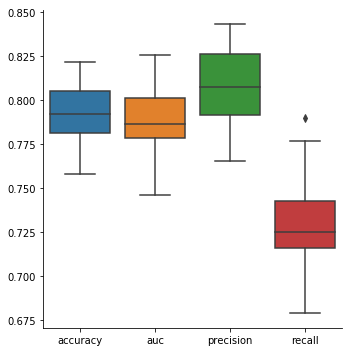

In [331]:

# use to plot performance of a given tree model over multiple trials

clf = DecisionTreeClassifier(max_depth=3)
tree_trial_plots(df_data, target, model=clf, n_trials=50)


In [335]:
# test out tree setting specific attributes to include

attributes=["cp","exang","slope","ca","thal"]

clf = DecisionTreeClassifier(max_depth=3)
result = run_10fold_tree_classifier(df_data[attributes], target, model=clf)
result

{'accuracy': 0.821264367816092,
 'auc': 0.8146895424836601,
 'error': 0.17873563218390803,
 'precision': 0.8390906479141773,
 'recall': 0.7645475113122172}